<a href="https://colab.research.google.com/github/bartteeuwen/USD-Applied-Data-Science-for-Business/blob/main/Police_Settlements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the dataset after uploading in content folder
df = pd.read_csv("/content/atlanta_edited.csv")

# Quick checks
print("Shape (rows, columns):", df.shape)
print("\nColumn names:")
print(df.columns.tolist())

print("\nFirst few rows:")

Shape (rows, columns): (65, 24)

Column names:
['claim_number', 'plaintiff_name', 'summary_allegations', 'amount_awarded', 'incident_date', 'closed_date', 'claim_or_lawsuit', 'city', 'state', 'denied_date', 'calendar_year', 'incident_year', 'matter_name', 'court', 'docket_number', 'filed_date', 'filed_year', 'location', 'other_expenses', 'collection', 'total_incurred', 'plaintiff_attorney', 'case_outcome', 'amount_demanded']

First few rows:


In [ ]:
# Check unique values
print(df["summary_allegations"].unique())

# Frequency count of each year
print(df["summary_allegations"].value_counts(dropna=False).sort_index())


['Department: Police; Summary Allegations: Other'
 'Department: Police; Summary Allegations: Wrongful arrest'
 'Department: Courts; Summary Allegations: Wrongful arrest'
 'Department: Police; Summary Allegations: Wrongful Demolition'
 'Department: Courts; Summary Allegations: Other'
 'Department: Police; Summary Allegations: Civil Rights Violation'
 'Department: Municipal Court; Summary Allegations: Wrongful Arrest'
 'Department: Police; Summary Allegations: Police Shooting'
 'Department: Municipal Court; Summary Allegations: Civil Rights Violation'
 'Department: Municipal Court; Summary Allegations: Wrongful arrest'
 'Department: Courts; Summary Allegations: Civil Rights Violations'
 'Department: Police; Summary Allegations: Civil Rights Violations'
 'Department: APD; Summary Allegations: Civil Rights Violation'
 'Department: Police; Summary Allegations: Other - Illegal Towing (Negligence)'
 'Department: Police; Summary Allegations: Other - Miscellaneous'
 'Department: Police; Summary

In [ ]:
import re
import numpy as np
import pandas as pd

# Split into department + allegation text
def split_summary(s):
    if pd.isna(s):
        return pd.Series([np.nan, np.nan])
    # normalize whitespace
    s = re.sub(r"\s+", " ", str(s)).strip()
    # split on ';' into "Department: ..." and "Summary Allegations: ..."
    parts = [p.strip() for p in s.split(";")]
    dept = next((p.split(":",1)[1].strip()
                 for p in parts if p.lower().startswith("department")), np.nan)
    summ = next((p.split(":",1)[1].strip()
                 for p in parts if p.lower().startswith("summary allegations")), np.nan)
    return pd.Series([dept, summ])

df[["dept","allegation_raw"]] = df["summary_allegations"].apply(split_summary)

# Normalize allegation text (lowercase, strip punctuation/plurals)
def norm(txt):
    if pd.isna(txt): return np.nan
    t = txt.lower()
    t = t.replace("violations", "violation")
    t = t.replace("–", "-").replace("—","-")
    t = re.sub(r"[()]", "", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["allegation_norm"] = df["allegation_raw"].apply(norm)

# 3) Pull out "other - <detail>" if present
def other_detail(t):
    if pd.isna(t): return np.nan
    m = re.match(r"other\s*-\s*(.*)", t)
    return m.group(1).strip() if m else np.nan

df["allegation_other_detail"] = df["allegation_norm"].apply(other_detail)

# Map data to a few clean categories
def map_category(t):
    if pd.isna(t): return np.nan
    if "civil rights" in t:                      return "Civil rights violation"
    if "wrongful arrest" in t:                   return "Wrongful arrest"
    if "police shooting" in t or "shooting" in t:return "Police shooting"
    if "motor vehicle" in t or "vehicle" in t:   return "Vehicle incident (negligence)"
    if "illegal towing" in t or "towing" in t:   return "Towing (negligence)"
    if "wrongful demolition" in t:               return "Demolition (negligence)"
    if "sidewalk defect" in t:                   return "Sidewalk/Infrastructure"
    if "regulatory licensing" in t:              return "Regulatory/licensing"
    if t.startswith("other"):                    return "Other (unspecified)"
    return "Other/uncategorized"

df["allegation_category"] = df["allegation_norm"].apply(map_category)

display(df[["dept","allegation_raw","allegation_category","allegation_other_detail"]].head(12))

# Counts for potential use in summary
cat_counts = df["allegation_category"].value_counts(dropna=False)
print(cat_counts)

# Totals by category:
by_cat_amount = (df.groupby("allegation_category", dropna=False)["amount_awarded"]
                   .sum().sort_values(ascending=False))
print(by_cat_amount)

,dept,allegation_raw,allegation_category,allegation_other_detail
0,Police,Other,Other (unspecified),NaN
1,Police,Other,Other (unspecified),NaN
2,Police,Other,Other (unspecified),NaN
3,Police,Wrongful arrest,Wrongful arrest,NaN
4,Courts,Wrongful arrest,Wrongful arrest,NaN
5,Police,Other,Other (unspecified),NaN
6,Police,Other,Other (unspecified),NaN
7,Police,Wrongful Demolition,Demolition (negligence),NaN
8,Courts,Wrongful arrest,Wrongful arrest,NaN
9,Courts,Other,Other (unspecified),NaN


allegation_category
Civil rights violation           39
Other (unspecified)              10
Wrongful arrest                   8
Demolition (negligence)           2
Police shooting                   2
Towing (negligence)               1
Regulatory/licensing              1
Sidewalk/Infrastructure           1
Vehicle incident (negligence)     1
Name: count, dtype: int64
allegation_category
Civil rights violation           4419719.00
Wrongful arrest                   241483.72
Other (unspecified)                29036.04
Vehicle incident (negligence)      27500.00
Regulatory/licensing               20000.00
Demolition (negligence)            15538.50
Sidewalk/Infrastructure             6000.00
Police shooting                     1705.00
Towing (negligence)                  200.00
Name: amount_awarded, dtype: float64


In [ ]:
df.head()

,claim_number,plaintiff_name,summary_allegations,amount_awarded,incident_date,closed_date,claim_or_lawsuit,city,state,denied_date,...,collection,total_incurred,plaintiff_attorney,case_outcome,amount_demanded,dept,allegation_raw,allegation_norm,allegation_other_detail,allegation_category
0,14L0136-A,"Glenn, Mary B.",Department: Police; Summary Allegations: Other,1970.04,NaN,2014-09-10,claim,Atlanta,GA,NaN,...,NaN,NaN,NaN,NaN,NaN,Police,Other,other,NaN,Other (unspecified)
1,14L0440,"Massey, Allene W.",Department: Police; Summary Allegations: Other,179.00,NaN,2014-08-21,claim,Atlanta,GA,NaN,...,NaN,NaN,NaN,NaN,NaN,Police,Other,other,NaN,Other (unspecified)
2,14L0136,"Glenn, Mary B.",Department: Police; Summary Allegations: Other,100.00,NaN,2014-07-18,claim,Atlanta,GA,NaN,...,NaN,NaN,NaN,NaN,NaN,Police,Other,other,NaN,Other (unspecified)
3,14L0267,"Johanning, William",Department: Police; Summary Allegations: Wrong...,17500.00,NaN,2014-09-19,claim,Atlanta,GA,NaN,...,NaN,NaN,NaN,NaN,NaN,Police,Wrongful arrest,wrongful arrest,NaN,Wrongful arrest
4,13L0825,"Folsom, Kristen D.",Department: Courts; Summary Allegations: Wrong...,907.00,NaN,2015-01-12,claim,Atlanta,GA,NaN,...,NaN,NaN,NaN,NaN,NaN,Courts,Wrongful arrest,wrongful arrest,NaN,Wrongful arrest


In [ ]:
# Count missing values per column
missing = df.isna().sum().sort_values(ascending=False)

# Show top 10 columns with the most missing values
print("=== Missing Values by Column ===")
print(missing.head(10))

# show percentage missing for context
missing_pct = (df.isna().mean() * 100).round(1)
print("\n=== Percent Missing by Column ===")
print(missing_pct.head(10))

=== Missing Values by Column ===
collection                 65
location                   65
other_expenses             65
filed_date                 65
filed_year                 65
total_incurred             65
plaintiff_attorney         65
denied_date                63
allegation_other_detail    61
case_outcome               60
dtype: int64

=== Percent Missing by Column ===
claim_number           58.5
plaintiff_name         58.5
summary_allegations     0.0
amount_awarded          0.0
incident_date          72.3
closed_date             0.0
claim_or_lawsuit        0.0
city                    0.0
state                   0.0
denied_date            96.9
dtype: float64


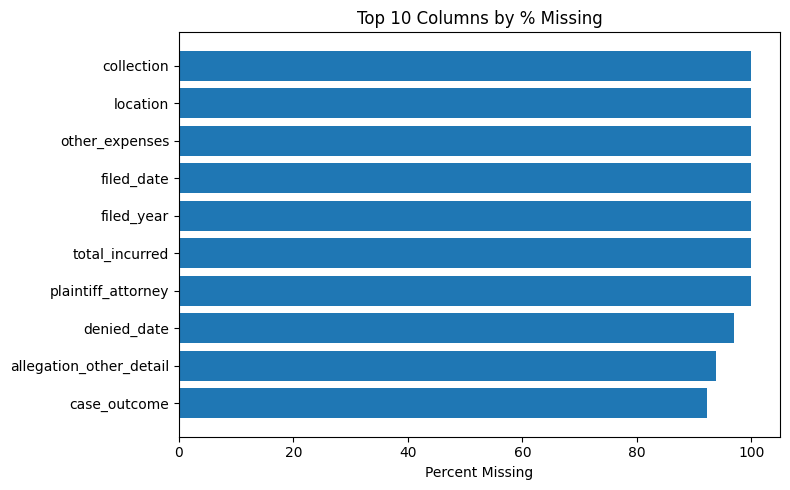

In [ ]:
import matplotlib.pyplot as plt

# % missing per column
missing_pct = (df.isna().mean() * 100).round(1)

# Top 10 by % missing
top = missing_pct.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
plt.barh(top.index, top.values)
plt.gca().invert_yaxis()  # highest % at top
plt.xlabel("Percent Missing")
plt.title("Top 10 Columns by % Missing")
plt.tight_layout()
plt.show()

In [ ]:
# Save a Tableau-ready CSV with the new columns
out_path = "/content/atlanta_edited2.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)

Saved: /content/atlanta_edited2.csv
